# 05_blob_feature.ipynb
### Create feature database of ocetrac blob features 


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops 
from dask_image.ndmeasure import label as label_dask
from skimage.measure import label as label_np


#### Import Ocetrac labels and SST data


In [2]:
file_path_list = ('/burg/abernathey/users/hillary/oisst_v21/ocetrac_notrend.nc',
        '/burg/abernathey/users/hillary/oisst_v21/positive_extremes_OISSTv21.nc')

ds = xr.open_mfdataset(file_path_list)
ds

<xarray.Dataset>
Dimensions:                     (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * month                       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * time                        (time) datetime64[ns] 1981-09-01 ... 2021-06-01
  * lat                         (lat) float32 -89.88 -89.62 ... 89.62 89.88
  * lon                         (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
Data variables:
    ssta_stn_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    prct_notrend                (month, lat, lon) float64 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend            (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino3_4  (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    mhw_ssta_notrend_noNino4    (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
    ocetrac_labels              (time, lat, lon) float64 dask.array<chunksize=(478, 720, 1440), meta=np.ndarray>
Attributes:
    description:  standardized SST anomalies above positive extreme threshold
    threshold:    0.9
    data:         preprocessed monthly averaged OISST v2.1

#### Feature Database

List of features to extract from the labeled dataset:
- inital latitude
- inital longitude
- final latitude
- final longitude
- duration
- number of centroids
- maximum distance between centroids
- mean intensity
- maximum intensity
- minimum intensity
- initial time (mm-yy)
- final time (mm-yy)
- Nino index



In [3]:
labels = ds.ocetrac_labels
num_events = labels.attrs['final objects tracked']


In [69]:
i=112
event = labels.where(labels==112, drop=True)
duration = event.time.shape[0]

In [5]:
coords = event.stack(z=('lat','lon')).dropna(dim='z')
coords

<xarray.DataArray 'ocetrac_labels' (time: 2, z: 1586)>
dask.array<getitem, shape=(2, 1586), dtype=float64, chunksize=(2, 1586), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1987-04-01 1987-05-01
  * z        (z) MultiIndex
  - lat      (z) float64 17.88 17.88 17.88 17.88 ... 26.88 26.88 26.88 26.88
  - lon      (z) float64 126.6 126.9 127.1 127.4 ... 140.6 140.9 141.1 141.4
Attributes:
    inital objects identified:  13856
    final objects tracked:      770
    radius:                     8
    size quantile threshold:    0.75
    min area:                   2527.0
    percent area reject:        0.19793256167051568
    percent area accept:        0.8020674383294844

In [6]:
# find ssta during event
event_ssta = ds.mhw_ssta_notrend.stack(z=('lat','lon')).where(coords).unstack()

In [70]:
binary_event = event.where(event>=0, other=0)
binary_event = binary_event.where(binary_event==0, other=1)

In [152]:
# X = coords.unstack().lon
# Y = coords.unstack().lon

In [176]:
# tmp = event.stack(z=('lat','lon')).dropna(dim='z').unstack()
# tmp


In [7]:
mean_intensity = event_ssta.mean(('lat','lon'))
max_intensity = event_ssta.max(('lat','lon'))
min_intensity = event_ssta.min(('lat','lon'))

In [76]:
ids, num = label_np(binary_event.astype('int').values, connectivity=2, return_num=True)

In [77]:
num

1

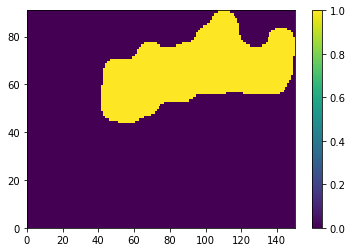

In [79]:
plt.pcolormesh(ids[0,:,:]); plt.colorbar()

In [42]:
labels = ds.ocetrac_labels.where(ds.ocetrac_labels>0, other=0, drop=False)
num_events = labels.attrs['final objects tracked']


In [91]:
event = labels.where(labels==112, drop=True)

In [92]:
event.shape

(2, 91, 150)

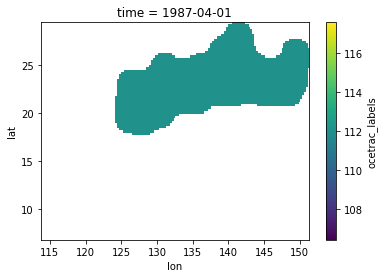

In [93]:
event[0,:,:].plot()
# plt.plot(inital_lon,inital_lat, '.', ms=12)

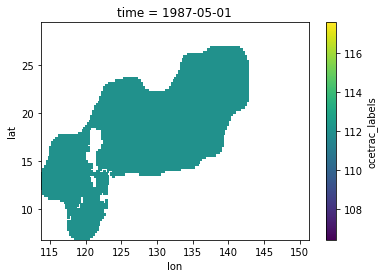

In [94]:
event[1,:,:].plot()

In [43]:
intensity_image = ds.ocetrac_labels.expand_dims(dim='ssta').transpose('time','lat','lon','ssta')
intensity_image = xr.concat([intensity_image, ds.mhw_ssta_notrend], dim="ssta")

In [44]:
props = regionprops(labels.astype('int').values, intensity_image=intensity_image.values)


In [99]:
i = 111

In [97]:
inital_lat = ds.lat[round(props[0].centroid[1])]
inital_lon = ds.lon[round(props[0].centroid[2])]


(0.0, 113.77323563440031, 1144.9394523717701)

In [96]:
coords = props[111].coords # (time, lat, lon)
duration = len(np.unique(corods[:,0])) # months
duration

2

In [90]:
props[111].label

112

In [ ]:
labelprops = [p.label for p in props]
labelprops = xr.DataArray(labelprops, dims=['label'], coords={'label': labelprops}) 
area = xr.DataArray([p.area for p in props], dims=['label'], coords={'label': labelprops})  # Number of pixels of the region.